In [1]:
import json
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.utils.data import DataLoader

from dictionary.dictionary_uk import PhonemeDictionaryUk
from preprocessor.preprocessor_uk import UkrainianProcessor

from dataloader.dataset import TextMelDataset
from dataloader.dataloader import collate_fn

from fastspeech.fast_speech import FastSpeech
from loss.fast_speech_loss import FastSpeechLoss

from fastspeech.postnet.postnet import PostNet
from fastspeech.transformer.encoder import Encoder
from fastspeech.transformer.decoder import Decoder
from fastspeech.regulators.variance_adaptor import VarianceAdaptor

from tts_fast_speech import TTS

/home/vitaliipsl/Projects/bachelor-project/model-new/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
with open('./config/fast_speech.json', 'r') as f:
    config = json.load(f)
config['training']

{'sr': 22050,
 'n_mels': 80,
 'n_fft': 1024,
 'hop_length': 256,
 'win_length': 1024,
 'num_epochs': 50,
 'batch_size': 32,
 'learning_rate': 0.01}

In [3]:
model_config = config['model']

In [4]:
encoder = Encoder(
    vocab_dim=model_config["vocab_size"],
    max_seq_len=model_config["max_seq_len"],
    emb_dim=model_config["enc_emb_dim"],
    num_layer=model_config["enc_num_layer"],
    num_head=model_config["enc_num_head"],
    h_dim=model_config["enc_emb_dim"],
    d_inner=model_config["enc_1d_filter_size"],
    dropout=model_config["dropout_prob"]
)

variance_adaptor = VarianceAdaptor(model_config)

decoder = Decoder(
    max_seq_len=model_config["max_seq_len"],
    emb_dim=model_config["dec_emb_dim"],
    num_layer=model_config["dec_num_layer"],
    num_head=model_config["dec_num_head"],
    h_dim=model_config["dec_emb_dim"],
    d_inner=model_config["dec_1d_filter_size"],
    mel_num=model_config["mel_num"],
    dropout=model_config["dropout_prob"]
)

postnet = PostNet(
    num_mel_bins=model_config["mel_num"],
    postnet_embedding_dim=model_config.get("postnet_embedding_dim", 512),
    postnet_kernel_size=model_config.get("postnet_kernel_size", 5),
    postnet_num_layers=model_config.get("postnet_num_layers", 5)
)

fast_speech = FastSpeech(model_config)

loss = FastSpeechLoss()

In [5]:
with open(config["dataset"]["metadata_path"], 'r') as f:
    metadata = json.load(f)

In [6]:
dictionary = PhonemeDictionaryUk()
preprocessor = UkrainianProcessor(dictionary)

dataset = TextMelDataset(preprocessor, config, metadata)
dataloader = DataLoader(dataset, batch_size=config["training"]["batch_size"], shuffle=True, collate_fn=collate_fn)

In [7]:
def visualize_mel_spectrogram(mel_spectrogram, example_index=0):
    # mel_spectrogram: [batch_size, seq_len, emb_dim]
    mel_spec = mel_spectrogram[example_index].detach().cpu().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.imshow(mel_spec.T, aspect='auto', origin='lower', interpolation='none')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.title('Mel Spectrogram')
    plt.show()

sequence shape: torch.Size([32, 55])
durations shape: torch.Size([32, 55])
mel_spectrogram shape: torch.Size([32, 80, 424])
encoder_outpute shape: torch.Size([32, 55, 256])
lr predictions shape: torch.Size([32, 424, 256])
durations predictions shape: torch.Size([32, 55])
mel_spectrogram prediction shape: torch.Size([32, 80, 424])
postnet_output shape: torch.Size([32, 80, 424])


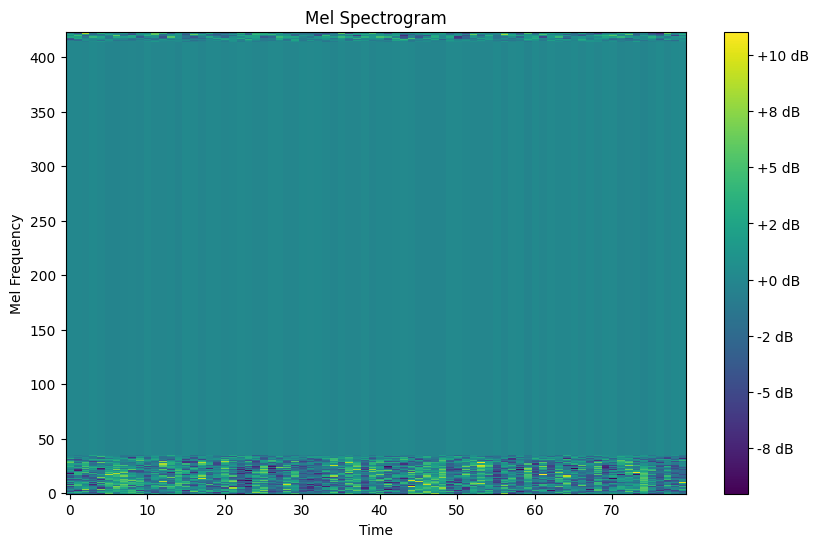

loss: 1.9154706001281738


In [8]:
for batch in dataloader:

    sequence = batch['sequence']
    print(f"sequence shape: {sequence.shape}")

    durations = batch['durations']
    print(f"durations shape: {durations.shape}")
    
    mel_spectrogram = batch['mel_spectrogram']
    print(f"mel_spectrogram shape: {mel_spectrogram.shape}")

    encoder_output = encoder(sequence)
    print(f"encoder_outpute shape: {encoder_output.shape}")
    
    lr_output, durations_output = variance_adaptor(encoder_output, mel_spectrogram.size()[2])
    print(f"lr predictions shape: {lr_output.shape}")
    print(f"durations predictions shape: {durations_output.shape}")
    
    mel_spectrogram = decoder(lr_output)
    print(f"mel_spectrogram prediction shape: {mel_spectrogram.shape}")
    
    postnet_output = postnet(mel_spectrogram)
    print(f"postnet_output shape: {postnet_output.shape}")
    
    mel_spectrogram_post = mel_spectrogram + postnet_output
    visualize_mel_spectrogram(mel_spectrogram_post, 0)
    
    loss = loss(mel_spectrogram_post, mel_spectrogram, durations_output, durations)
    print(f"loss: {loss}")
    
    break

sequence shape: torch.Size([32, 62])
mel_spectrogram shape: torch.Size([32, 80, 427])
output shape: torch.Size([32, 80, 427])
durations_output shape: torch.Size([32, 62])


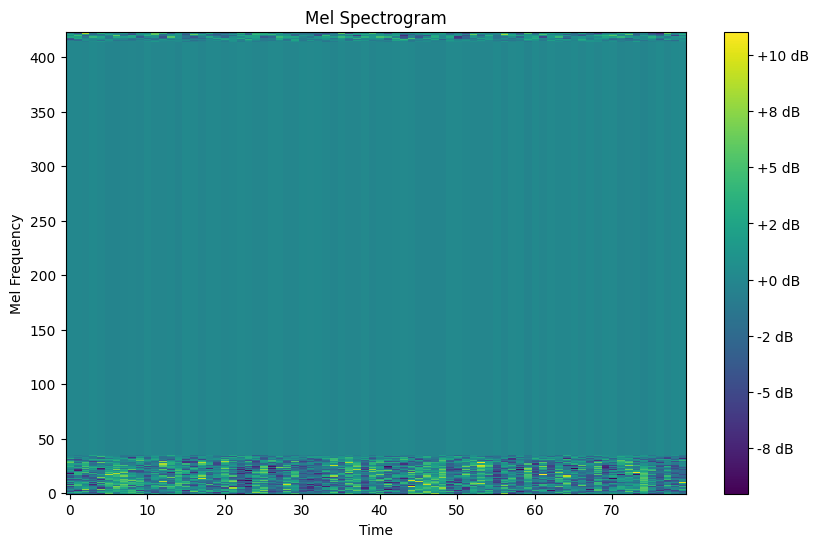

In [9]:
for batch in dataloader:

    sequence = batch['sequence']
    print(f"sequence shape: {sequence.shape}")
    
    mel_spectrogram = batch['mel_spectrogram']
    print(f"mel_spectrogram shape: {mel_spectrogram.shape}")
    
    output, durations_output = fast_speech(sequence, mel_spectrogram.size()[2])
    print(f"output shape: {output.shape}")
    print(f"durations_output shape: {durations_output.shape}")
    
    visualize_mel_spectrogram(mel_spectrogram_post, 0)

    break
    

In [10]:
tts = TTS(model_config)
output = tts.infer('Хоч би воно й сталося так, то не боюся.')
print(output)

tensor([[[-1.3194, -2.3016,  1.4452,  ..., -0.4379,  0.3010,  0.5462],
         [-0.9585,  1.0211, -0.7403,  ...,  1.3596,  2.3918,  0.8735],
         [ 0.2770, -0.4058, -0.0126,  ..., -0.1969,  2.2406, -0.2058],
         ...,
         [ 0.4205,  0.3535, -2.1423,  ..., -0.8266,  0.4938, -0.5625],
         [-0.2386,  1.0119,  0.4098,  ...,  0.2377,  0.0786, -0.1167],
         [ 2.3704, -0.2426, -0.7170,  ..., -0.1198, -0.5535, -0.4078]]])
